In [1]:
import sys
import neal
import greedy
import tabu
import time
import numpy as np

from pathlib import Path
current_path = Path().resolve()
sys.path.append(str(current_path / '../code/'))
from experiment import Experiment
from table import Table
from visualisation import Figure

# Load the data

In [2]:
data_folder = '../data/Multidimensional Knapsack/'
# Weish dataset has smallers problebls, WEING has larger problems.
# We have Weish[01-30] files in Weish folder. Load them.
weish_files_no = 30
weish_file_paths = ['weish//Weish'+ str(i).zfill(2) +'.npz' for i in range(1, weish_files_no + 1)]
weish_loaded_files = [np.load(data_folder + i) for i in weish_file_paths]
# We have WEING[1-8] files in Weing folder. Load them.
weing_files_no = 8
weing_file_paths = ['weing//WEING'+ str(i) +'.npz' for i in range(1, weing_files_no + 1)]
weing_loaded_files = [np.load(data_folder + i) for i in weing_file_paths]
# Merge the datasets and get the needed information.
loaded_files = weish_loaded_files + weing_loaded_files
qubo_sizes = [i['n'] for i in loaded_files]
objectives = [i['objective'] for i in loaded_files]
constraints = [i['constraint'] for i in loaded_files]

# Prepare the data

In [3]:
minimisation = False # This is a maximisation problem
QUBOs, penalties, obj_qubos, obj_constants, con_qubos, con_constants = Experiment.data_prep(qubo_sizes, objectives, constraints, 'Verma&Lewis', minimisation)

# Run experiments

In [13]:
# The number of samples we want the sampler to return
repeats = 1 #10

## Greedy

In [23]:
greedy_sampler = greedy.SteepestDescentSampler()
greedy_runs = Experiment.run_sampler(QUBOs, obj_qubos, obj_constants, con_qubos, con_constants, 
                                     greedy_sampler, repeats, num_reads=1800)

100.0 %
CPU times: user 29.5 s, sys: 160 ms, total: 29.7 s
Wall time: 29.9 s


## Simulated Annealing

In [26]:
sa_sampler = neal.SimulatedAnnealingSampler()
sa_runs = Experiment.run_sampler(QUBOs, obj_qubos, obj_constants, con_qubos, con_constants, 
                                 sa_sampler, repeats, num_reads=130)

100.0 %
CPU times: user 29 s, sys: 90.5 ms, total: 29.1 s
Wall time: 29.2 s


## Tabu

In [29]:
tabu_sampler = tabu.TabuSampler()
tabu_runs = Experiment.run_sampler(QUBOs, obj_qubos, obj_constants, con_qubos, con_constants, 
                                   tabu_sampler, repeats, timeout=800)

100.0 %
CPU times: user 30.4 s, sys: 108 ms, total: 30.5 s
Wall time: 30.6 s


# Record the results

In [30]:
greedy_results = Table.record_results(greedy_runs, qubo_sizes, penalties, repeats)
sa_results = Table.record_results(sa_runs, qubo_sizes, penalties, repeats)
tabu_results = Table.record_results(tabu_runs, qubo_sizes, penalties, repeats)

# Display the first repetition table
rep = 0
Table.display_side_by_side(greedy_results[rep], sa_results[rep], tabu_results[rep], titles=['Greedy', 'SA', 'Tabu'])

,Size,Penalty,Objective Function,Broken Constraints,Energy (minimisation)
0,85,892,2831,0,-2831
1,85,892,1828,0,-1828
2,90,892,3009,1,-2117
3,85,892,1023,3,1653
4,90,892,2203,0,-2203
5,100,892,1103,1,-211
6,100,892,3050,0,-3050
7,100,892,2338,0,-2338
8,100,892,1185,2,599
9,110,892,3604,9,4424


# Explore the results

In [31]:
# Show total energies of all tries in all problems in a single df
energies_greedy = Table.columns_to_table(greedy_results, 'Energy (minimisation)')
energies_sa = Table.columns_to_table(sa_results, 'Energy (minimisation)')
energies_tabu = Table.columns_to_table(tabu_results, 'Energy (minimisation)')

energies_tabu

,Energy (minimisation) 0
0,-851
1,-881
2,-2242
3,-557
4,-514
5,-2804
6,377
7,40
8,-2266
9,-3166


In [32]:
# Show number of broken constraints of all tries in all problems in a single df
broken_constraints_greedy = Table.columns_to_table(greedy_results, 'Broken Constraints')
broken_constraints_sa = Table.columns_to_table(sa_results, 'Broken Constraints')
broken_constraints_tabu = Table.columns_to_table(tabu_results, 'Broken Constraints')

broken_constraints_greedy

,Broken Constraints 0
0,0
1,0
2,1
3,3
4,0
5,1
6,0
7,0
8,2
9,9


In [33]:
# Show feasible solutions
feasible_full_greedy = Table.feasibility_table(greedy_results)
feasible_full_sa = Table.feasibility_table(sa_results)
feasible_full_tabu = Table.feasibility_table(tabu_results)

feasible_full_tabu

,Feasible 0
0,False
1,True
2,True
3,True
4,False
5,False
6,False
7,False
8,True
9,True


This is the final and the most important table. It displays the number of feasible solutions achieved for every problem, the feasibility rate (feasible_soultions/total_solutions), the mean energy of the solutions and the standard deviation.

In [34]:
# Calculate number of feasible solutions with mean and SD (in all runs)
feasible_greedy = Table.feasibility_statistic(greedy_results)
feasible_sa = Table.feasibility_statistic(sa_results)
feasible_tabu = Table.feasibility_statistic(tabu_results)

# Display the table
Table.display_side_by_side(feasible_greedy, feasible_sa, feasible_tabu, titles=['Greedy', 'SA', 'Tabu'])

,Feasible,Feasibility rate,Energy mean,Energy SD
0,1.000000,1.000000,-2.831000e+03,NaN
1,1.000000,1.000000,-1.828000e+03,NaN
2,0.000000,0.000000,-2.117000e+03,NaN
3,0.000000,0.000000,1.653000e+03,NaN
4,1.000000,1.000000,-2.203000e+03,NaN
5,0.000000,0.000000,-2.110000e+02,NaN
6,1.000000,1.000000,-3.050000e+03,NaN
7,1.000000,1.000000,-2.338000e+03,NaN
8,0.000000,0.000000,5.990000e+02,NaN
9,0.000000,0.000000,4.424000e+03,NaN


## Greedy Algorithm Run Length Distribution

In [4]:
# Solve QUBO a lot of times
problem_num = 25
seed = 0
repeats = 10000
sampler = greedy.SteepestDescentSampler()
response =  sampler.sample_qubo(QUBOs[problem_num], seed=seed, num_reads=repeats)

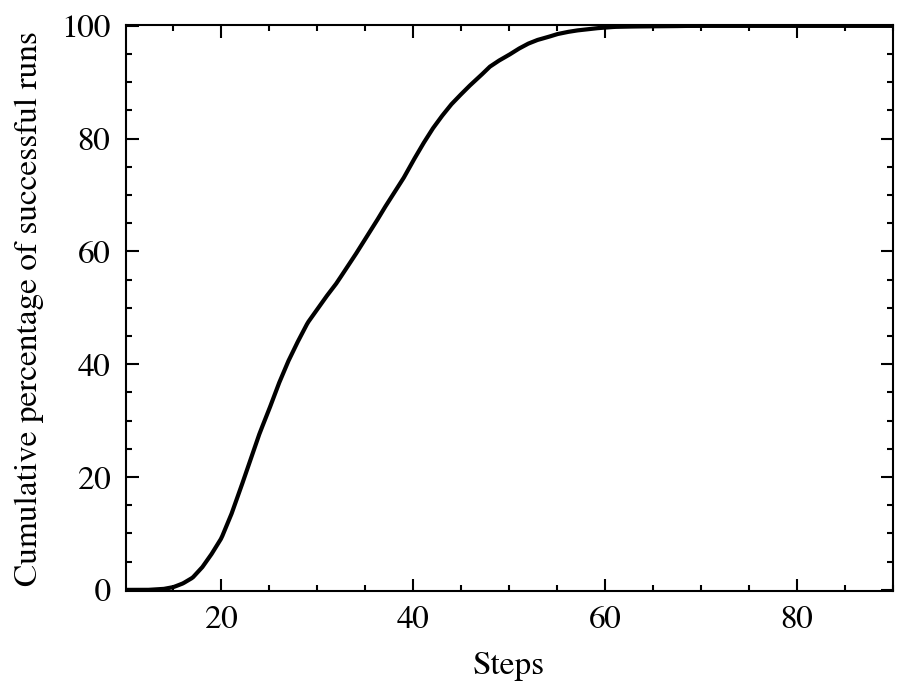

In [5]:
Figure.run_length_distribution(response)

## Tabu Search Run Time Distribution

In [6]:
times = []
energies = []
sampler = tabu.TabuSampler()
repeats = 1000
# Hyperparameters
timeout = 10 # default 20
problem_num = 25

# num_restarts has to be 1 (Towards a Characterisation of the Behaviour of Stochastic Local Search Algorithms for SAT)
# Therefore, use seed hack to simulate multiple runs
for seed in range(1, repeats):
    # Record start time
    start = time.time()
    # Run algorithms
    response =  sampler.sample_qubo(QUBOs[problem_num], seed=seed, timeout=timeout, num_reads=1, num_restarts=1)
    # Record end time and find the difference, which is equivalent to run time
    end = time.time()
    times.append(end - start)
    data = response.data(fields=['energy'])
    energy = next(data).energy
    energies.append(energy)

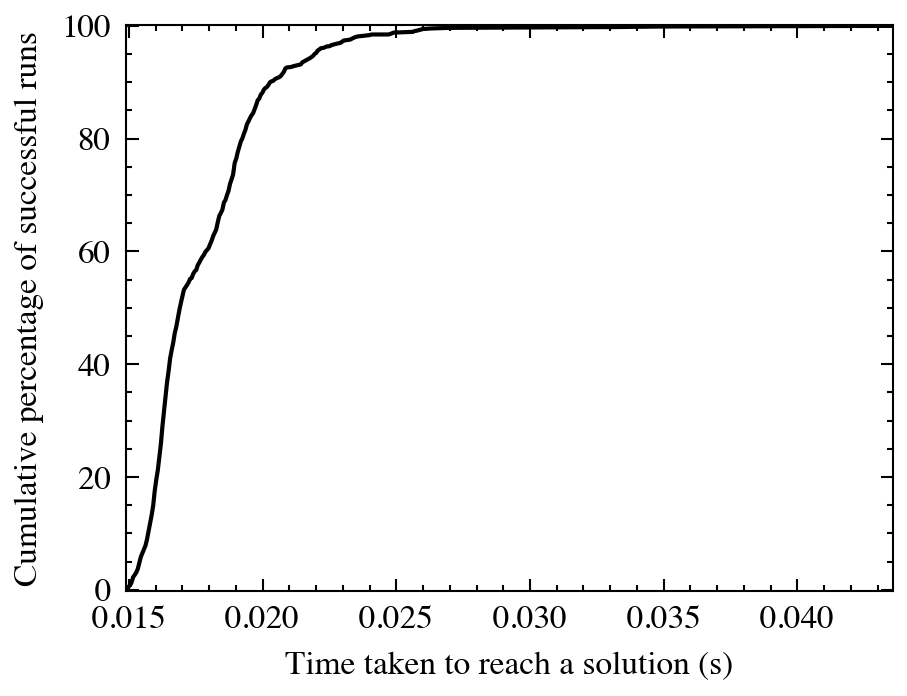

In [7]:
Figure.run_time_distribution(times, energies)

# Save results

In [40]:
data_folder = '../Data/Produced/'
broken_constraints_greedy.to_pickle(data_folder + 'monotone_greedy_broken_constraints.pkl')
broken_constraints_sa.to_pickle(data_folder + 'monotone_sa_broken_constraints.pkl')
broken_constraints_tabu.to_pickle(data_folder + 'monotone_tabu_broken_constraints.pkl')